#### Fine Modeling — `tb_meta` + XGBoost + Optuna (Purged CV)
### 
#### Focus: rank-quality first (AUC/PR-AUC), then choose execution threshold `p*` on VALIDATION.
#### - Purged/embargoed CV for Optuna (no leakage).
#### - Early stopping per fold and final fit (monitored on VAL).
#### - Class/event weighting for imbalance.
#### - Hold-out probability calibration on VAL (isotonic if enough positives else sigmoid).
#### - `p*` from VAL with a minimum-trades fallback.
#### - Quiet warnings / quiet Optuna logs.


In [ ]:

import sys, os, json, pickle, warnings
import numpy as np
import pandas as pd
import optuna
import inspect
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss
from sklearn.base import clone

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

# Silence the noisy stuff
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", module="sklearn.calibration")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Add repo root for module imports (adjust if needed)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from xgboost import XGBClassifier
from src.modelling_functions import (
    build_datasets_for_models,
    base_rule_ma_cross,
    meta_decision,
    calculate_sharpe_with_costs,
    best_threshold,
    purged_time_series_splits,
    pick_split_by_event_count
)

In [ ]:
# Configuration
CONFIG = {
    "data_path": r"C:\Users\epoch_bpjmdqk\Documents\Code\data\processed\consumer_staples_data.csv",
    "target_ticker": "WMT",
    "span_vol": 20,
    "H": 10,             # embargo/purge horizon (in bars) used by your split fn
    "pt": 1.0,
    "sl": 1.0,
    "train_end": "2015-12-31",
    "val_end": "2019-12-31",
    "transaction_cost": 0.001,
    "random_state": 42,
    "n_trials": 80,
    "opt_metric": "pr_auc",  # 'roc_auc' | 'pr_auc' | 'logloss'
    "min_trades_val": 5,     # ensure p* chosen fires at least this many times on VAL
}

In [ ]:
# Data & event matrix
data = pd.read_csv(CONFIG["data_path"], index_col="Date", parse_dates=True)
close = data[f'Close_{CONFIG["target_ticker"]}'].astype(float)

# Drop raw OHLC for target to reduce trivial leakage
X_base = data.drop(columns=[
    f'Open_{CONFIG["target_ticker"]}',
    f'High_{CONFIG["target_ticker"]}',
    f'Low_{CONFIG["target_ticker"]}',
    f'Close_{CONFIG["target_ticker"]}',
], errors='ignore')

base_side = base_rule_ma_cross(close, fast=10, slow=20)

packs = build_datasets_for_models(
    X=X_base,
    close=close,
    span_vol=CONFIG["span_vol"],
    H=CONFIG["H"],
    pt_sl=(CONFIG["pt"], CONFIG["sl"]),
    base_side=base_side,
)

X_events = packs["meta_X"]
y_events = packs["meta_y"]          # 0/1 (take/skip)
side_events = packs["meta_side"]    # +1/-1
t1_events = packs["meta_t1"]
w_events = packs.get("meta_weights", None)

print("Event matrix:", X_events.shape, "Labels:", y_events.value_counts().to_dict())

# Train / Val / Test splits by date
X_train = X_events.loc[:CONFIG["train_end"]]
y_train = y_events.loc[:CONFIG["train_end"]]
side_train = side_events.loc[:CONFIG["train_end"]]
t1_train = t1_events.loc[:CONFIG["train_end"]]

X_val = X_events.loc[CONFIG["train_end"]:CONFIG["val_end"]]
y_val = y_events.loc[CONFIG["train_end"]:CONFIG["val_end"]]
side_val = side_events.loc[CONFIG["train_end"]:CONFIG["val_end"]]

X_test = X_events.loc[CONFIG["val_end"]:]
y_test = y_events.loc[CONFIG["val_end"]:]
side_test = side_events.loc[CONFIG["val_end"]:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Event matrix: (554, 288) Labels: {1: 298, 0: 256}
Train: (497, 288) Val: (26, 288) Test: (31, 288)


In [4]:
# %%
# ======================
# Helpers (can be moved into src/modelling_functions.py)
# ======================

def make_calibrator(estimator, method="sigmoid", cv="prefit"):
    """
    Wrap CalibratedClassifierCV for sklearn version differences.
    If estimator is already fit, pass cv='prefit' and call .fit(X_val, y_val).
    """
    try:
        return CalibratedClassifierCV(estimator=estimator, method=method, cv=cv)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=estimator, method=method, cv=cv)

def build_tb_meta_pipeline_xgb(params: dict, selector_threshold: str = "median") -> Pipeline:
    # Keep XGB quiet and consistent
    base_est = XGBClassifier(**{**params, "verbosity": 0})
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("selector", SelectFromModel(base_est, threshold=selector_threshold)),
        ("model", XGBClassifier(**{**params, "verbosity": 0}))
    ])
    return pipe

def make_sample_weights(y: pd.Series, event_weights: pd.Series | None) -> np.ndarray:
    """Class weight: pos gets neg/pos; multiply by event weights if provided."""
    pos = int((y == 1).sum())
    neg = int((y == 0).sum())
    cw = (neg / max(pos, 1))
    w = np.where(y.values == 1, cw, 1.0).astype(float)
    if event_weights is not None:
        ew = event_weights.reindex(y.index).fillna(1.0).values
        w = w * ew
    return w

def fold_fit_score(pipe, X_tr, y_tr, X_va, y_va, sample_weight_tr=None, metric="pr_auc"):
    """Fit with early stopping on the fold VAL; return desired metric on VAL."""
    fit_params = {
        "model__eval_set": [(X_va, y_va)],
        "model__early_stopping_rounds": 50,
        "model__verbose": False
    }
    if sample_weight_tr is not None:
        # CHANGE inside fold_fit_score: replace the whole fit block with just this line
        _fit_with_es(pipe, X_tr, y_tr, X_va, y_va, sample_weight_tr=sample_weight_tr, rounds=50)
    else:
        pipe.fit(X_tr, y_tr, **fit_params)

    proba = pipe.predict_proba(X_va)[:, 1]
    if metric == "roc_auc":
        s = roc_auc_score(y_va, proba)
    elif metric == "pr_auc":
        s = average_precision_score(y_va, proba)
    elif metric == "logloss":
        s = -log_loss(y_va, proba, labels=[0, 1])
    else:
        raise ValueError("Unknown metric")
    return float(s)

def make_optuna_objective(
    X, y, t1, H, event_weights=None, sampler_seed=42, use_selector=True, metric="pr_auc"
):
    def objective(trial: optuna.trial.Trial) -> float:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 150, 800),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 20.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "eval_metric": "logloss",
            "random_state": sampler_seed,
            "n_jobs": -1,
            "tree_method": "hist",
        }
        selector_threshold = trial.suggest_categorical(
            "selector_threshold", ["median", "mean", "0.75*mean"]
        ) if use_selector else "median"

        pipe = build_tb_meta_pipeline_xgb(params, selector_threshold)

        splits = list(purged_time_series_splits(
            X.index, t1.reindex(X.index), n_splits=3, test_size=None, embargo=H
        ))

        scores = []
        for tr_idx, va_idx in splits:
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
            sw_tr = make_sample_weights(
                y_tr, event_weights.reindex(y_tr.index) if event_weights is not None else None
            )
            s = fold_fit_score(pipe, X_tr, y_tr, X_va, y_va, sample_weight_tr=sw_tr, metric=metric)
            scores.append(s)

        return float(np.nanmean(scores)) if scores else -10.0
    return objective

def fit_calibrate_choose_pstar(pipe, X_train, y_train, X_val, y_val, side_val, close,
                               event_weights_train=None, min_trades=5, default_p=0.55):
    """Fit on TRAIN (ES on VAL), calibrate on VAL, choose p* on VAL with min-trades fallback."""
    fit_params = {
        "model__eval_set": [(X_val, y_val)],
        "model__early_stopping_rounds": 50,
        "model__verbose": False
    }
    # CHANGE inside fit_calibrate_choose_pstar: replace the fit block with just these lines
    sw_train = make_sample_weights(
        y_train, event_weights_train.reindex(y_train.index) if event_weights_train is not None else None
    )
    _fit_with_es(pipe, X_train, y_train, X_val, y_val, sample_weight_tr=sw_train, rounds=50)


    cal_method = "isotonic" if int(y_val.sum()) >= 50 else "sigmoid"
    calibrator = make_calibrator(pipe, method=cal_method, cv="prefit")
    # IMPORTANT: with cv='prefit', pass VAL as calibration set here:
    calibrator.fit(X_val, y_val)

    proba_val = pd.Series(calibrator.predict_proba(X_val)[:, 1], index=X_val.index)
    # Try economic threshold first
    try:
        p_star = best_threshold(proba_val.values, side_val, close, X_val.index)
    except Exception:
        p_star = None
    if p_star is None or np.isnan(p_star):
        p_star = default_p

    # Ensure at least `min_trades` VAL signals
    n_trades = int((proba_val >= p_star).sum())
    if n_trades < min_trades:
        for q in (0.98, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55):
            cand = float(np.quantile(proba_val, q))
            if int((proba_val >= cand).sum()) >= min_trades:
                p_star = cand
                break

    return calibrator, float(p_star), cal_method

def metrics_dict(y_true, proba):
    return dict(
        auc=float(roc_auc_score(y_true, proba)) if len(np.unique(y_true)) > 1 else np.nan,
        pr_auc=float(average_precision_score(y_true, proba)) if len(np.unique(y_true)) > 1 else np.nan,
        brier=float(brier_score_loss(y_true, proba)),
        logloss=float(log_loss(y_true, proba, labels=[0, 1]))
    )

# REPLACE your current _fit_with_es helper with this version
def _fit_with_es(pipe, X_tr, y_tr, X_va, y_va, sample_weight_tr=None, rounds=50):
    """
    Fit the pipeline manually:
      imputer.fit_transform -> selector.fit/transform -> model.fit
    Use early stopping via whichever signature this XGBoost version supports.
    """
    # Unpack steps
    imputer = pipe.named_steps["imputer"]
    selector = pipe.named_steps["selector"]
    model   = pipe.named_steps["model"]

    # 1) Preprocess
    Xtr_imp = imputer.fit_transform(X_tr)
    Xva_imp = imputer.transform(X_va)

    selector.fit(Xtr_imp, y_tr)
    Xtr_sel = selector.transform(Xtr_imp)
    Xva_sel = selector.transform(Xva_imp)

    # 2) Build version-safe fit kwargs for XGBClassifier
    sig = inspect.signature(model.fit)
    fit_kwargs = {}
    if "eval_set" in sig.parameters:
        fit_kwargs["eval_set"] = [(Xva_sel, y_va)]
    if "verbose" in sig.parameters:
        fit_kwargs["verbose"] = False
    if "early_stopping_rounds" in sig.parameters:
        fit_kwargs["early_stopping_rounds"] = rounds
    elif "callbacks" in sig.parameters:
        es = xgb.callback.EarlyStopping(rounds=rounds, save_best=True)
        fit_kwargs["callbacks"] = [es]

    # 3) Fit model
    if sample_weight_tr is not None and "sample_weight" in sig.parameters:
        model.fit(Xtr_sel, y_tr, sample_weight=sample_weight_tr, **fit_kwargs)
    else:
        model.fit(Xtr_sel, y_tr, **fit_kwargs)

    # 4) Put fitted steps back (pipeline will use them for predict_proba)
    pipe.named_steps["imputer"] = imputer
    pipe.named_steps["selector"] = selector
    pipe.named_steps["model"] = model
    return pipe




In [5]:
# Optuna study (TRAIN only)
objective = make_optuna_objective(
    X=X_train, y=y_train, t1=t1_train, H=CONFIG["H"],
    event_weights=w_events, sampler_seed=CONFIG["random_state"],
    metric=CONFIG["opt_metric"]
)

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=CONFIG["random_state"])
)
study.optimize(objective, n_trials=CONFIG["n_trials"], show_progress_bar=True)

print(f"Best CV {CONFIG['opt_metric'].upper()}: {study.best_value:.4f}")
print("Best params:", study.best_params)

best_params = study.best_params.copy()
selector_threshold = best_params.pop("selector_threshold", "median")

  0%|          | 0/80 [00:00<?, ?it/s]

Best CV PR_AUC: 0.5936
Best params: {'n_estimators': 562, 'learning_rate': 0.1462316688161845, 'max_depth': 4, 'subsample': 0.9872682720362675, 'colsample_bytree': 0.8861346669586112, 'min_child_weight': 10, 'gamma': 3.5869944034792307, 'reg_lambda': 16.894827568202246, 'reg_alpha': 3.8872693746308533, 'selector_threshold': 'median'}


In [6]:
# Final fit on TRAIN (ES on VAL) -> Calibrate on VAL -> choose p* on VAL
pipe = build_tb_meta_pipeline_xgb(best_params, selector_threshold)
prob_model, p_star, calibration_method = fit_calibrate_choose_pstar(
    pipe, X_train, y_train, X_val, y_val, side_val, close,
    event_weights_train=w_events if w_events is not None else None,
    min_trades=CONFIG["min_trades_val"], default_p=0.55
)

In [7]:
# Probability diagnostics (Train/Val/Test)
proba_train = pd.Series(prob_model.predict_proba(X_train)[:, 1], index=X_train.index)
proba_val   = pd.Series(prob_model.predict_proba(X_val)[:, 1],   index=X_val.index)
proba_test  = pd.Series(prob_model.predict_proba(X_test)[:, 1],  index=X_test.index)

m_train = metrics_dict(y_train, proba_train)
m_val   = metrics_dict(y_val,   proba_val)
m_test  = metrics_dict(y_test,  proba_test)

print(f"\nTrain: AUC={m_train['auc']:.3f}  PR-AUC={m_train['pr_auc']:.3f}  "
      f"Brier={m_train['brier']:.4f}  LogLoss={m_train['logloss']:.4f}")
print(f"Val:   AUC={m_val['auc']:.3f}  PR-AUC={m_val['pr_auc']:.3f}  "
      f"Brier={m_val['brier']:.4f}  LogLoss={m_val['logloss']:.4f}")
print(f"Test:  AUC={m_test['auc']:.3f}  PR-AUC={m_test['pr_auc']:.3f}  "
      f"Brier={m_test['brier']:.4f}  LogLoss={m_test['logloss']:.4f}")

print(f"\nChosen p* from validation: {p_star:.3f}")


Train: AUC=0.737  PR-AUC=0.753  Brier=0.2249  LogLoss=0.6401
Val:   AUC=0.739  PR-AUC=0.740  Brier=0.2042  LogLoss=0.5989
Test:  AUC=0.338  PR-AUC=0.459  Brier=0.3048  LogLoss=0.8172

Chosen p* from validation: 0.500


n_test_events: 31
Test Sharpe (costs): 0.493
n_nonzero_signals: 24


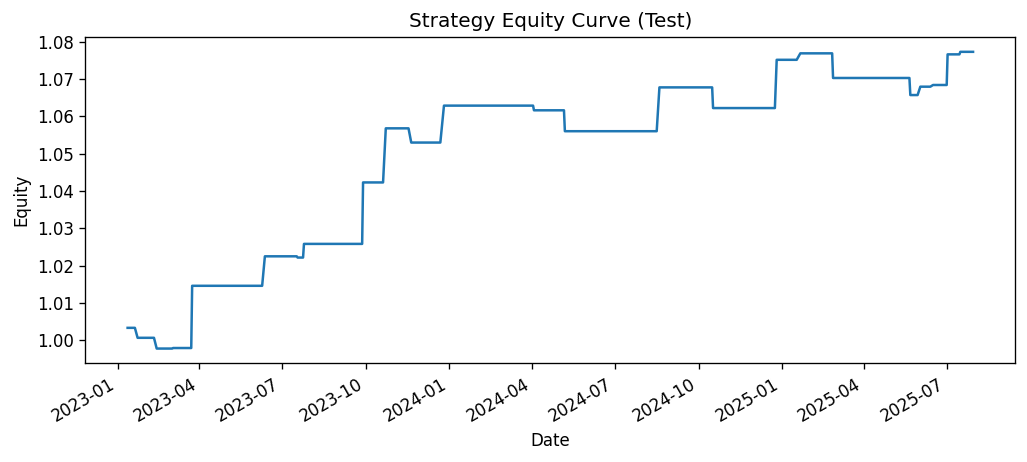

p* = 0.5 
proba_test quantiles:
 0.50    0.684169
0.80    0.740310
0.90    0.775383
0.95    0.778579
0.99    0.778579
dtype: float64


In [ ]:
# Turn probabilities into Test trades & plot equity
signals_test = meta_decision(proba_test.values, side=side_test, p_star=p_star)

print("n_test_events:", len(X_test))
if not signals_test.empty:
    days = close.loc[signals_test.index.min():signals_test.index.max()].index
    daily_signal = signals_test.reindex(days).fillna(0).astype(float)
    daily_ret = close.pct_change().shift(-1).reindex(days).fillna(0.0)
    pnl = daily_signal * daily_ret

    sharpe = float(calculate_sharpe_with_costs(pnl, transaction_cost=CONFIG["transaction_cost"]))
    print(f"Test Sharpe (costs): {sharpe:.3f}")
    print("n_nonzero_signals:", int((daily_signal != 0).sum()))

    (1 + pnl).cumprod().plot(figsize=(10, 4))
    plt.title("Strategy Equity Curve (Test)")
    plt.xlabel("Date"); plt.ylabel("Equity")
    plt.show()
else:
    print("No signals generated on Test with chosen p* (min-trades fallback should make this rare).")

# Probability distribution vs p*
q = proba_test.quantile([.5, .8, .9, .95, .99])
print("p* =", round(p_star, 3), "\nproba_test quantiles:\n", q)

In [9]:
# Save calibrated probability model + metadata
out_dir = os.path.join(os.path.dirname(CONFIG["data_path"]), "..", "models")
os.makedirs(out_dir, exist_ok=True)

model_path = os.path.join(out_dir, "tb_meta_xgb_prob_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(prob_model, f)

meta = {
    "config": CONFIG,
    "best_params": best_params,
    "selector_threshold": selector_threshold,
    "calibration_method": calibration_method,
    "p_star": float(p_star),
    "train_events": int(len(X_train)),
    "val_events": int(len(X_val)),
    "test_events": int(len(X_test)),
    "train_auc": m_train["auc"],
    "val_auc": m_val["auc"],
    "test_auc": m_test["auc"],
}
with open(os.path.join(out_dir, "tb_meta_xgb_metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved probability model to:", model_path)

Saved probability model to: C:\Users\epoch_bpjmdqk\Documents\Code\data\processed\..\models\tb_meta_xgb_prob_model.pkl
